In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    ax.imshow(img)

def show_anns_cell(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((anns[0].shape[0], anns[0].shape[1], 4))
    img[:,:,3] = 0
    for ann in anns:
        m = ann
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    ax.imshow(img)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

## Example image

In [6]:
image = cv2.imread("/home/wd/data/for_sam_test/2023_03_17_YVV845_01_R3D.png")#cv2.imread('images/dog.jpg')
# new_image = np.zeros((image.shape[0],image.shape[1],3), dtype=np.uint8)
# new_image[:,:,0] = ((image.max() - image)/(image.max() - image.min())*255).astype(np.uint8)
# im1 = image//255
# new_image[:,:,1] = ((image.max() - image)/(image.max() - image.min())*255).astype(np.uint8)
#im1 = image%255
# new_image[:,:,2] = ((im1.max() - im1)/(im1.max() - im1.min())*255).astype(np.uint8)
# image = image[:,:,None]
#image = ((image.max() - image)/(image.max() - image.min())*255).astype(np.uint8)
#image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

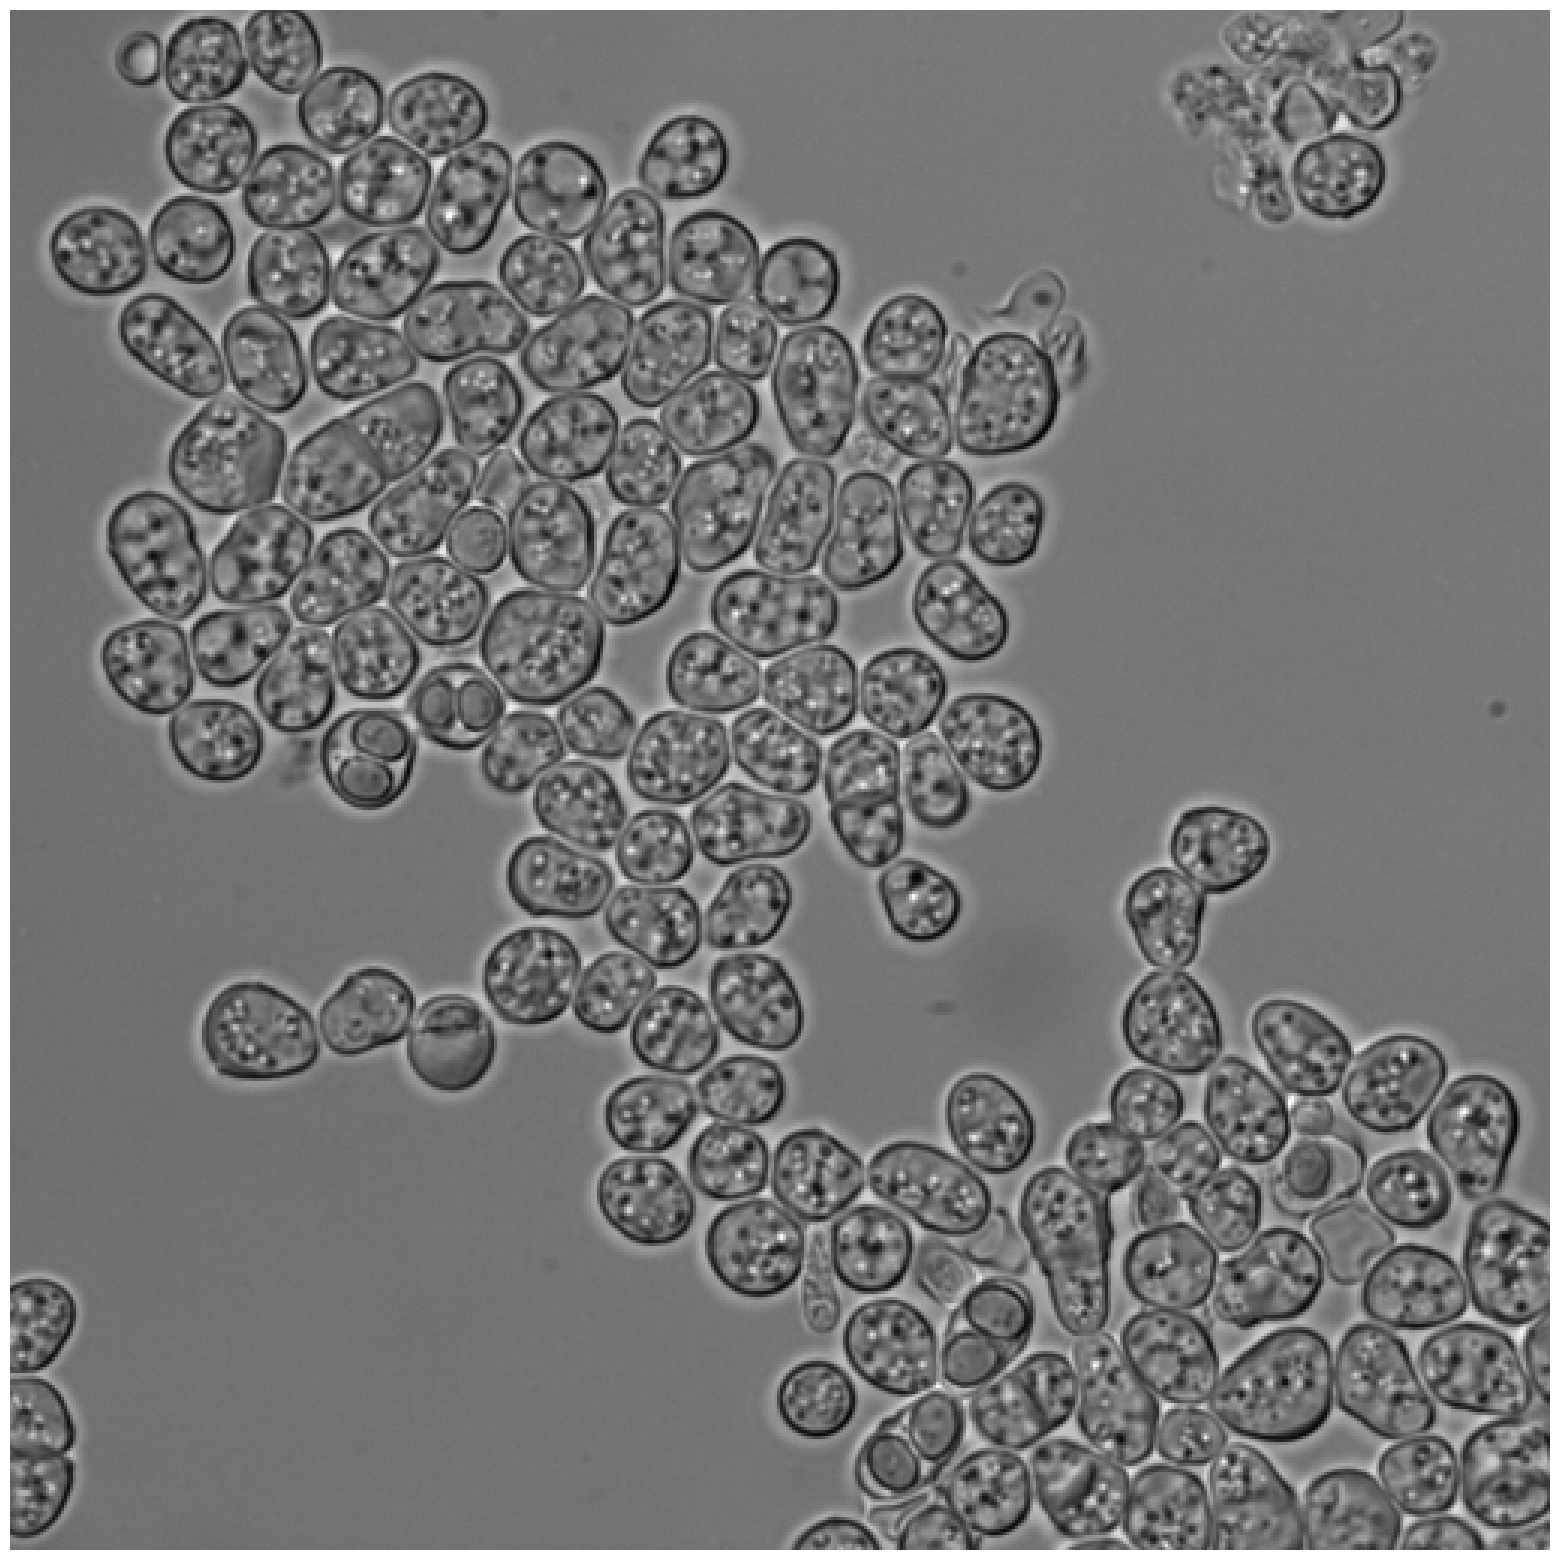

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(image[:,:,:])
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor, SamAutomaticCellGenerator
from segment_anything.utils.amg import generate_crop_boxes

In [9]:

sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
# predictor = SamPredictor(sam)

In [69]:
mask_generator2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    points_per_batch=32,
    pred_iou_thresh=0.96,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=1,
    crop_overlap_ratio=0.3,
    min_mask_region_area=500,  # Requires open-cv to run post-processing
)

In [75]:
image = cv2.imread("/home/wd/data/for_sam_test/.png")#cv2.imread('images/dog.jpg')

In [76]:
masks2 = mask_generator2.generate(image)
sores = [masks2[i]["stability_score"] for i in range(0, len(masks2))]
thres = [masks2[i]["predicted_iou"] for i in range(0, len(masks2))]

crop_w = 333, crop_h = 333
5


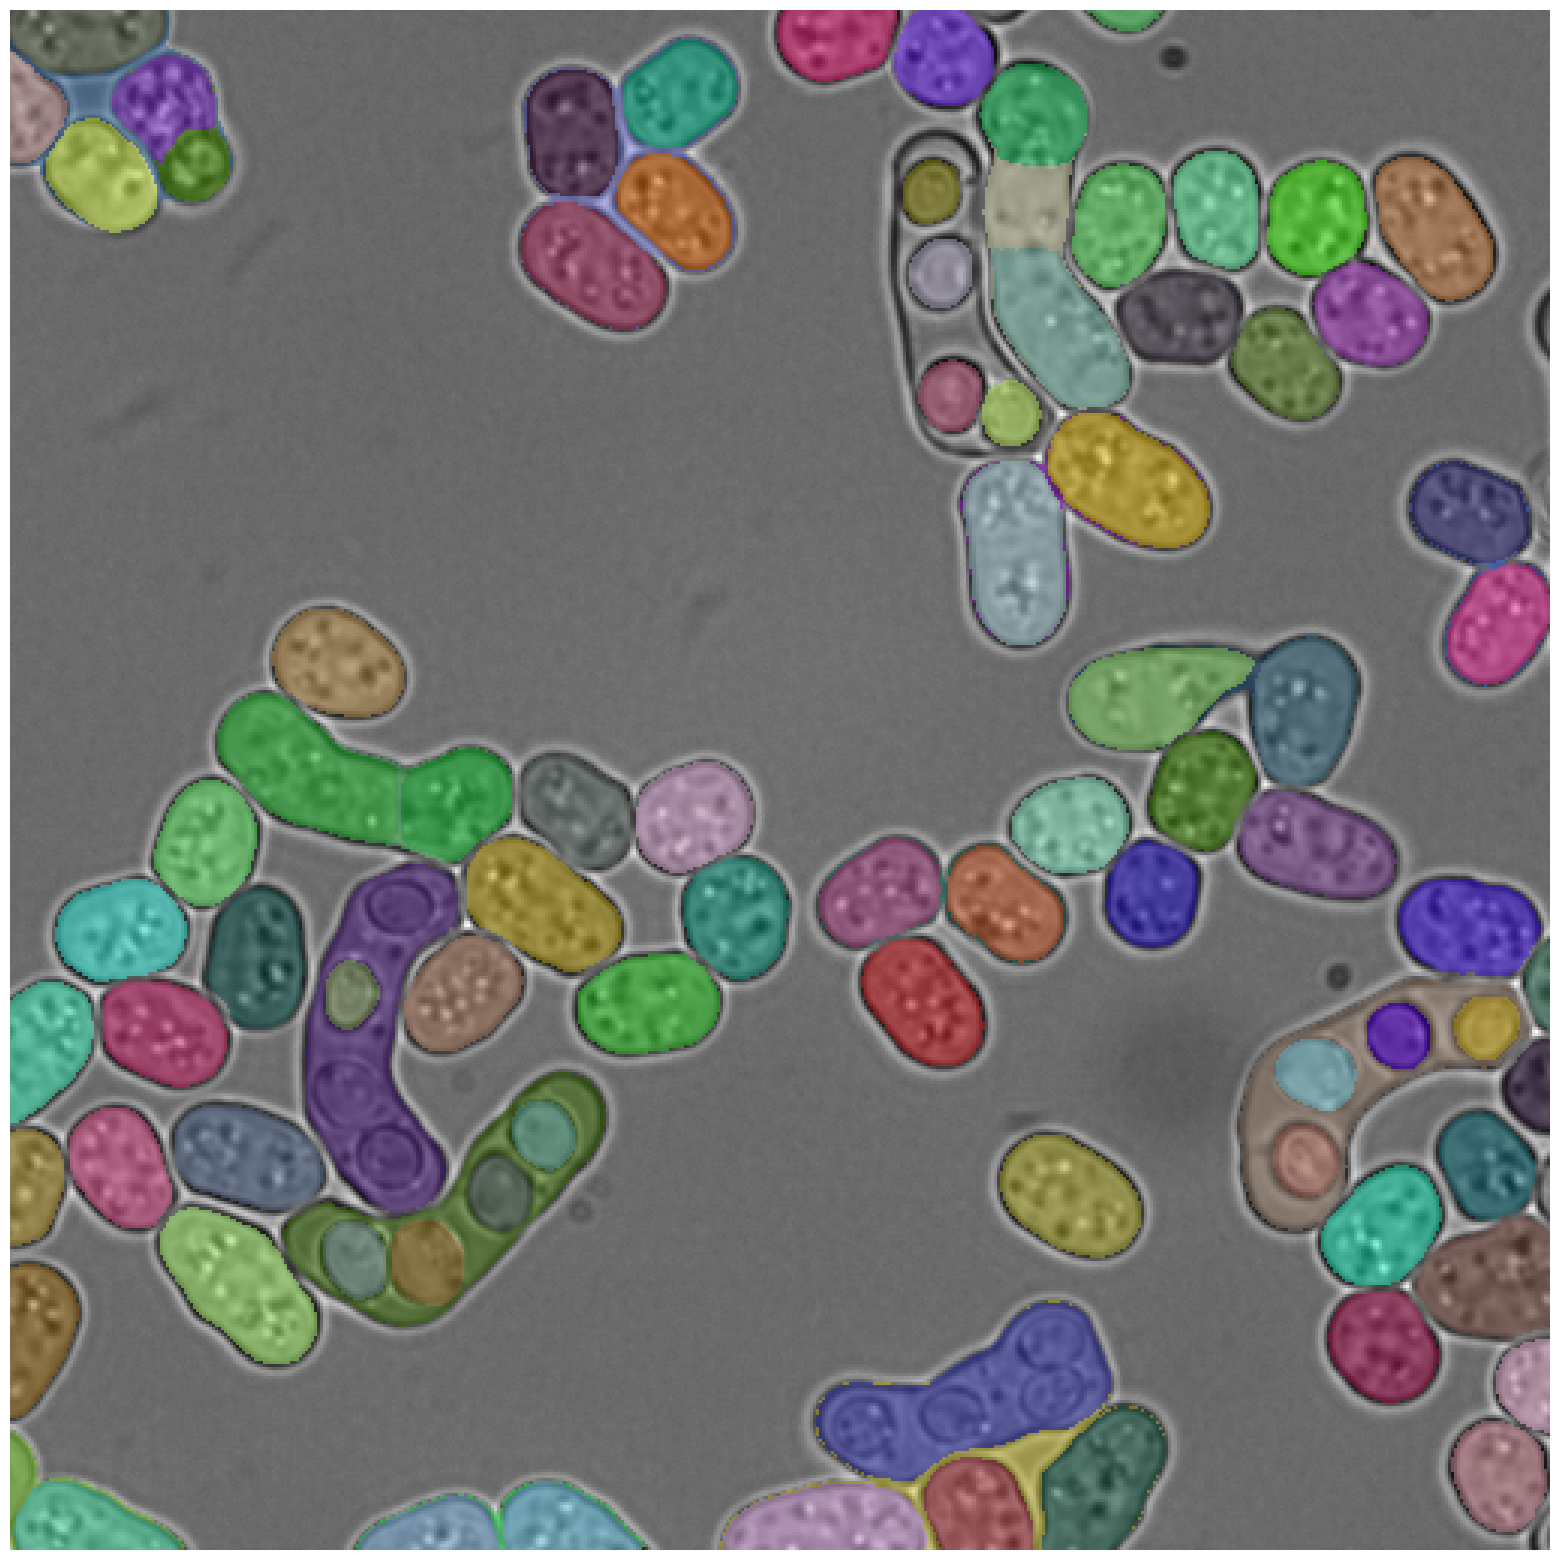

In [77]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
# plt.savefig("/home/wd/data/for_sam_test/seg_00.png")
plt.show() 

In [78]:
all_data = []
for i in range(0, len(masks2)):
    all_data.append(masks2[i]['segmentation'])
all_data = np.array(all_data)

In [79]:
np.save("/home/wd/data/for_sam_test/REF_06", all_data)